In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy


c:\Users\Vasanth M\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading Dataset

In [2]:
dataset, dataset_info = tfds.load("malaria", with_info= True,as_supervised  =True, shuffle_files = True, split = ["train"])

In [8]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)

    train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

    val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
    val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

    test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
    return train_dataset, val_dataset, test_dataset

In [9]:
TRAIN_RATIO= 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

print(list(train_dataset.take(1).as_numpy_iterator()), list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 0)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

In [10]:
len(test_dataset)

2757

# Dataset Visualization      

In [11]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path='C:\\Users\\Vasanth M\\tensorflow_datasets\\malaria\\1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in 

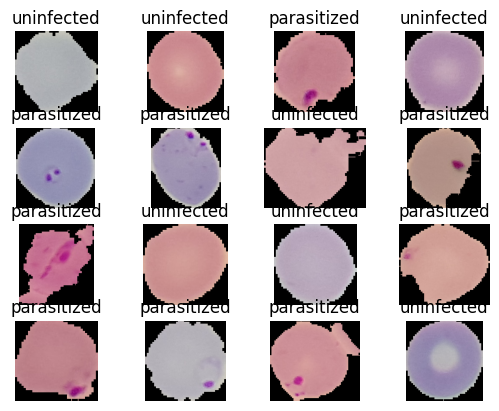

In [12]:
for i , (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(image)
    plt.title(dataset_info.features["label"].int2str(label))
    plt.axis("off")

# Data Preprocessing

In [13]:
#  resizing 
IM_SIZE = 224
def resize_rescale(image, label):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [14]:

train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)


In [15]:
for image, label in train_dataset.take(1):
    print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(0, shape=(), dtype=int64)


In [16]:
BATCH_SIZE = 32

train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [17]:

val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [18]:
val_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [19]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [20]:
print(list(train_dataset.take(1).as_numpy_iterator()))

[(array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],


       [[[0., 0., 0.],
         [0., 0., 0.],
         [0.

# Model Creating

In [21]:
lenet_model = tf.keras.Sequential([
                             InputLayer(input_shape = (IM_SIZE,IM_SIZE, 3)),
                             
                             Conv2D(filters = 6,kernel_size =3 ,strides= 1,padding='valid', activation = "relu"),
                             BatchNormalization(),
                             MaxPool2D(pool_size = 2, strides = 2),

                             Conv2D(filters = 16,kernel_size =3 ,strides= 1,padding='valid', activation = "relu"),
                             BatchNormalization(),
                             MaxPool2D(pool_size = 2, strides = 2),

                             Flatten(),

                             Dense(100, activation = "relu"),
                             BatchNormalization(),
                             Dense(10, activation = "relu"),
                             BatchNormalization(),
                             Dense(1, activation = "sigmoid"),
        
])
lenet_model.summary()





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 16)     64        
 hNormalization)                                                 
                                                        

# Functional API

In [22]:
func_input = Input(shape =(224,224, 3), name = "Input Image" )

x = Conv2D(filters = 6,kernel_size =3 ,strides= 1,padding='valid', activation = "relu")(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = 2, strides = 2)(x)


x = Conv2D(filters = 16,kernel_size =3 ,strides= 1,padding='valid', activation = "relu")(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size = 2, strides = 2)(x)


        
feature_extract_model  = Model(func_input, output, name= "feature_extracter")
feature_extract_model.summary()



Model: "feature_extracter"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Batc  (None, 222, 222, 6)      24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 6)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Batc  (None, 109, 109, 16

# Callable Model

In [23]:
func_input = Input(shape =(224,224, 3), name = "Input Image" )

x = feature_extract_model(func_input)


x = Flatten()(x)


x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)


x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)


func_output = Dense(1, activation = "sigmoid")(x)
        
lenet_model_func  = Model(func_input, func_output, name= "Lenet_Model")
lenet_model_func.summary()



Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extracter (Function  (None, 54, 54, 16)       1136      
 al)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 46656)             0         
                                                                 
 dense_3 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_6 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 10)                

# Model Subclassing

In [24]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size,):
    super(FeatureExtractor, self).__init__()

    self.conv_1 = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D (pool_size = pool_size, strides= 2*strides)

    self.conv_2 = Conv2D(filters = filters*2, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D (pool_size = pool_size, strides= 2*strides)

  def call(self, x, training):

    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)

    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x
feature_sub_classed = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

In [25]:
func_input = Input(shape =(224,224, 3), name = "Input Image" )

x = feature_sub_classed(func_input)


x = Flatten()(x)


x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)


x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)


func_output = Dense(1, activation = "sigmoid")(x)
        
lenet_model_func  = Model(func_input, func_output, name= "Lenet_Model")
lenet_model_func.summary()



Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor (FeatureE  (None, 54, 54, 16)       1488      
 xtractor)                                                       
                                                                 
 flatten_2 (Flatten)         (None, 46656)             0         
                                                                 
 dense_6 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_10 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 dense_7 (Dense)             (None, 10)                

In [41]:
class LenetModel(Model):
  def __init__(self):
    super(LenetModel, self).__init__()

    self.feature_extractor = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

    self.flatten = Flatten()

    self.dense_1 = Dense(100, activation = "relu")
    self.batch_1 = BatchNormalization()

    self.dense_2 = Dense(10, activation = "relu")
    self.batch_2 = BatchNormalization()

    self.dense_3 = Dense(1, activation = "sigmoid")
    
  def call(self, x, training):

    x = self.feature_extractor(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.batch_1(x)
    x = self.dense_2(x)
    x = self.batch_2(x)
    x = self.dense_3(x)

    return x
    
lenet_sub_classed = LenetModel()
lenet_sub_classed(tf.zeros([1,224,224,3]))
lenet_sub_classed.summary()

Model: "lenet_model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_14 (Featu  multiple                 1488      
 reExtractor)                                                    
                                                                 
 flatten_15 (Flatten)        multiple                  0         
                                                                 
 dense_45 (Dense)            multiple                  4665700   
                                                                 
 batch_normalization_64 (Bat  multiple                 400       
 chNormalization)                                                
                                                                 
 dense_46 (Dense)            multiple                  1010      
                                                                 
 batch_normalization_65 (Bat  multiple              

# Custom Layers

In [ ]:
class NeuralearnDense(Layer):
    def _init_(self):
        super(NeuralearnDense, self)._init_()
        

# Model training

In [43]:
lenet_sub_classed.compile(optimizer= Adam(learning_rate= 0.01) ,loss = BinaryCrossentropy(), metrics = "accuracy")


In [44]:
history = lenet_sub_classed.fit(train_dataset ,validation_data= val_dataset ,epochs= 5, verbose=1)

Epoch 1/5
689/689 [==============================] - 516s 747ms/step - loss: 0.3007 - accuracy: 0.8807 - val_loss: 0.2385 - val_accuracy: 0.9169
Epoch 2/5
689/689 [==============================] - 612s 889ms/step - loss: 0.1988 - accuracy: 0.9332 - val_loss: 0.1543 - val_accuracy: 0.9499
Epoch 3/5
689/689 [==============================] - 3353s 5s/step - loss: 0.1968 - accuracy: 0.9340 - val_loss: 0.8087 - val_accuracy: 0.8113
Epoch 4/5
689/689 [==============================] - 2660s 4s/step - loss: 0.2928 - accuracy: 0.8975 - val_loss: 7.1637 - val_accuracy: 0.9292
Epoch 5/5
689/689 [==============================] - 505s 734ms/step - loss: 0.2152 - accuracy: 0.9304 - val_loss: 1.7896 - val_accuracy: 0.9310


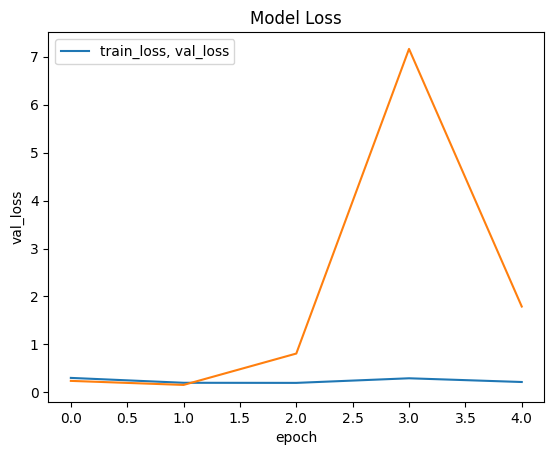

In [46]:

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("epoch")
plt.ylabel("val_loss")
plt.legend(["train_loss, val_loss"])
plt.show()

# Model Evaluation and testing

In [47]:
test_dataset= test_dataset.batch(1)

In [48]:
test_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [50]:
lenet_sub_classed.evaluate(test_dataset)

2757/2757 [==============================] - 36s 12ms/step - loss: 3.8775 - accuracy: 0.9195


[3.8775453567504883, 0.9194777011871338]

In [51]:
def parasite_or_not(x):
    if(x<0.5):
        return str("P")
    else:
        return str("U")

In [52]:
parasite_or_not(lenet_sub_classed.predict(test_dataset.take(1))[0][0])


1/1 [==============================] - 3s 3s/step


'P'

1/1 [==============================] - 0s 32ms/step


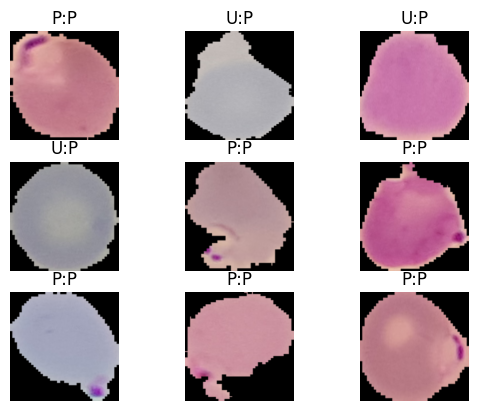

In [53]:
for i , (image, label) in enumerate(test_dataset.take(9)):

    ax = plt.subplot(3, 3, i+1)

    plt.imshow(image[0])
    plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(lenet_model.predict(image)[0][0])))

    plt.axis("off")

# Loading and Saving

In [54]:
# save configuration and weights
lenet_sub_classed.save("LeneSavedModel")

INFO:tensorflow:Assets written to: LeneSavedModel\assets


INFO:tensorflow:Assets written to: LeneSavedModel\assets


In [55]:
lenet_load_model = tf.keras.models.load_model("LeneSavedModel")

In [56]:
lenet_load_model.summary()

Model: "lenet_model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_14 (Featu  multiple                 1488      
 reExtractor)                                                    
                                                                 
 flatten_15 (Flatten)        multiple                  0         
                                                                 
 dense_45 (Dense)            multiple                  4665700   
                                                                 
 batch_normalization_64 (Bat  multiple                 400       
 chNormalization)                                                
                                                                 
 dense_46 (Dense)            multiple                  1010      
                                                                 
 batch_normalization_65 (Bat  multiple              

1/1 [==============================] - 0s 33ms/step


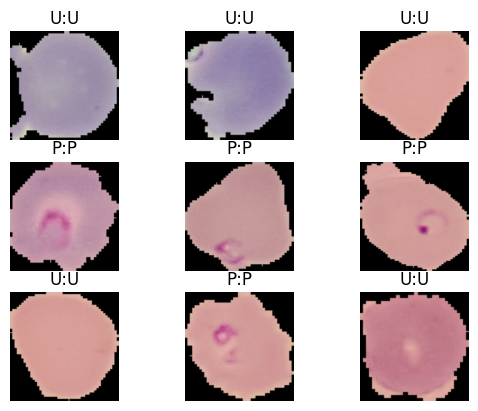

In [57]:
for i , (image, label) in enumerate(test_dataset.take(9)):

    ax = plt.subplot(3, 3, i+1)

    plt.imshow(image[0])
    plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(lenet_load_model.predict(image)[0][0])))

    plt.axis("off")

In [60]:
# lenet_sub_classed.save("LeneSavedModel.hdf5")


In [59]:
# saves weights alone
lenet_sub_classed.save_weights("weights/LeneSavedModel")
